# Plot motion parameters for each run

In [1]:
%matplotlib inline
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from glob import glob
from os.path import join, basename, splitext

In [2]:
# Directions per http://web.mit.edu/fsl_v5.0.8/fsl/doc/wiki/POSSUM(2f)UserGuide.html
rot_dirs = ['Pitch', 'Roll', 'Yaw']
trans_dirs = ['X', 'Y', 'Z']
colors = sns.color_palette('husl')

data_dir = '/scratch/PSB6351_2017/students/salo/data/'
out_dir = '/scratch/PSB6351_2017/students/salo/week06/plots/'

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = [12, 8]

In [3]:
# Get ylims
subjects = [f for f in glob(join(data_dir, 'sub-*'))]
r_lim = 0.
t_lim = 0.
for s in subjects:
    motpar_files = sorted([f for f in glob(join(s, 'preproc/motion/*.par'))])
    for f in motpar_files:
        dat = np.loadtxt(f)
        t, r = dat[:, :3], dat[:, 3:]
        r_lim = np.max([r_lim, np.max(np.abs(r))])
        t_lim = np.max([t_lim, np.max(np.abs(t))])
r_lim = np.ceil(r_lim * 100.) / 100.
t_lim = np.ceil(t_lim * 10.) / 10.

In [4]:
def framewise_displacement(vals):
    mot_pars = np.copy(vals)
    mot_pars[:, 3:] = mot_pars[:, 3:] * 50  # Convert radians to mm
    mot_pars = np.vstack((np.array([[0, 0, 0, 0, 0, 0]]),
                          np.diff(mot_pars, axis=0)))
    fd = np.sum(np.abs(mot_pars), axis=1)
    return fd

sub-01
sub-02
sub-03
sub-04
sub-05
sub-06
sub-07
sub-09
sub-10
sub-11
sub-12


/home/data/nbc/ns-vs-bm/ns-vs-bm/env/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


sub-13
sub-14
sub-15


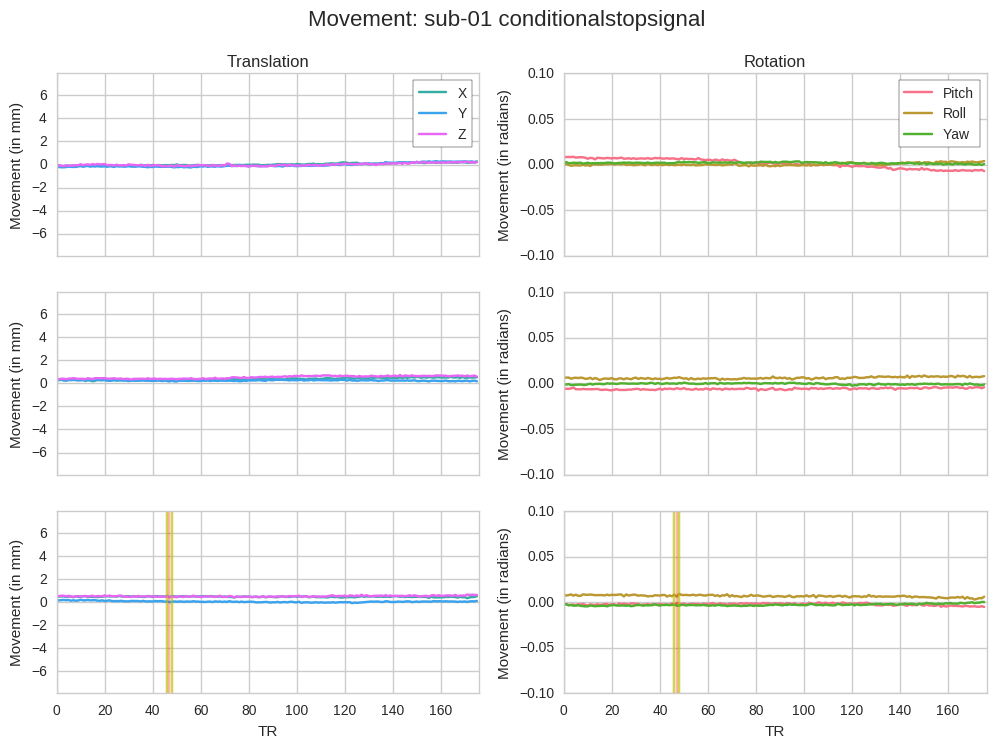

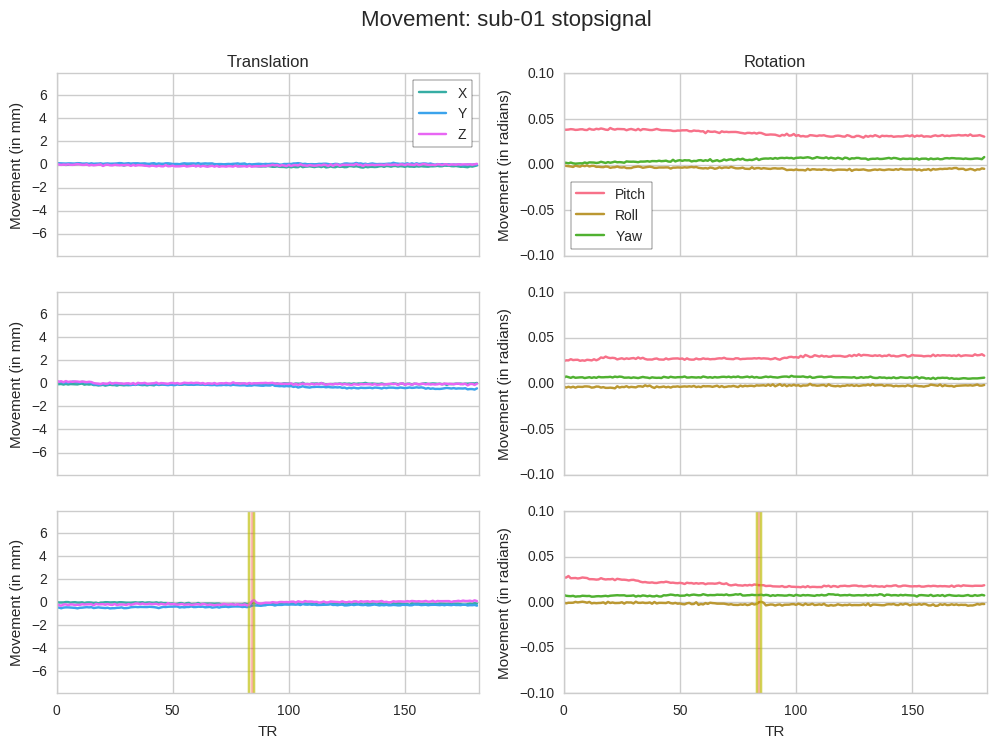

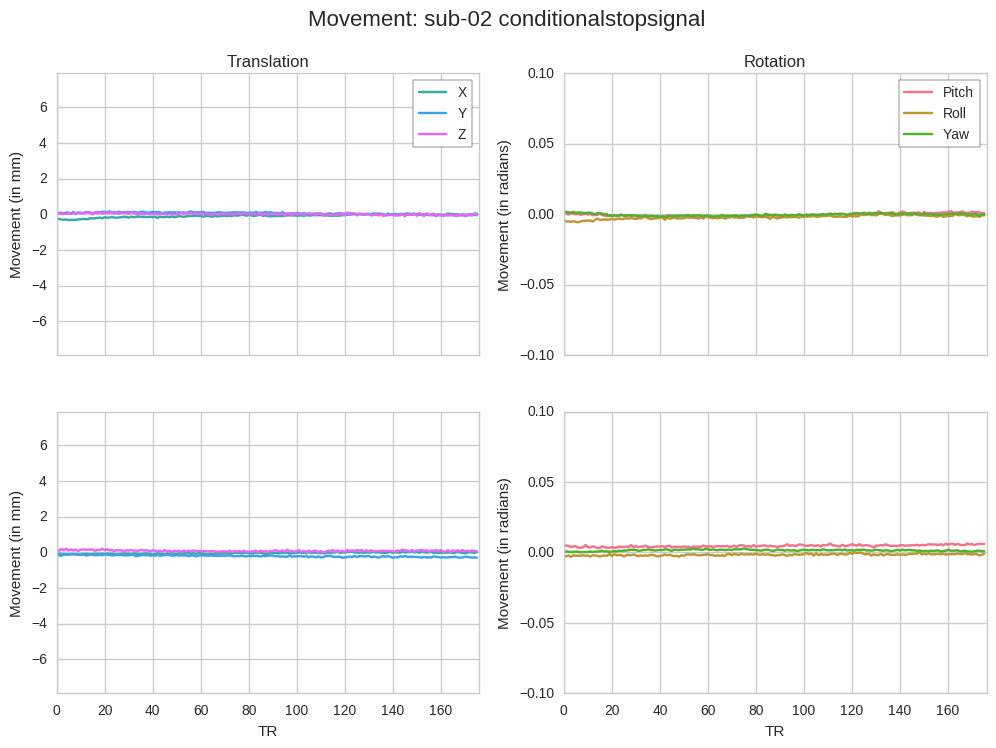

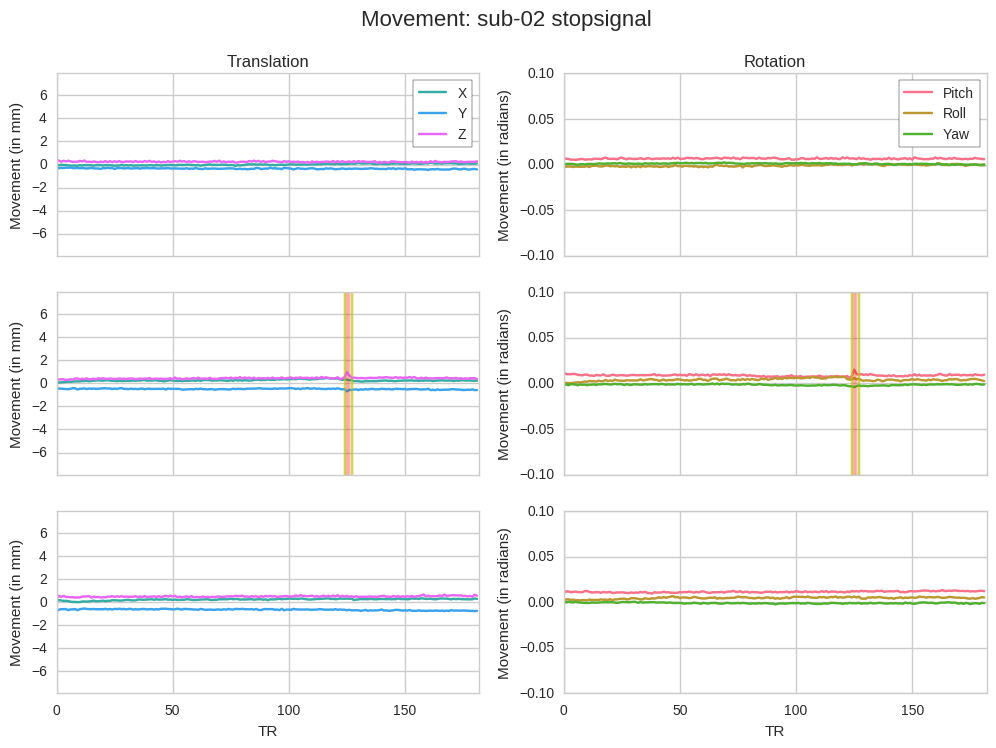

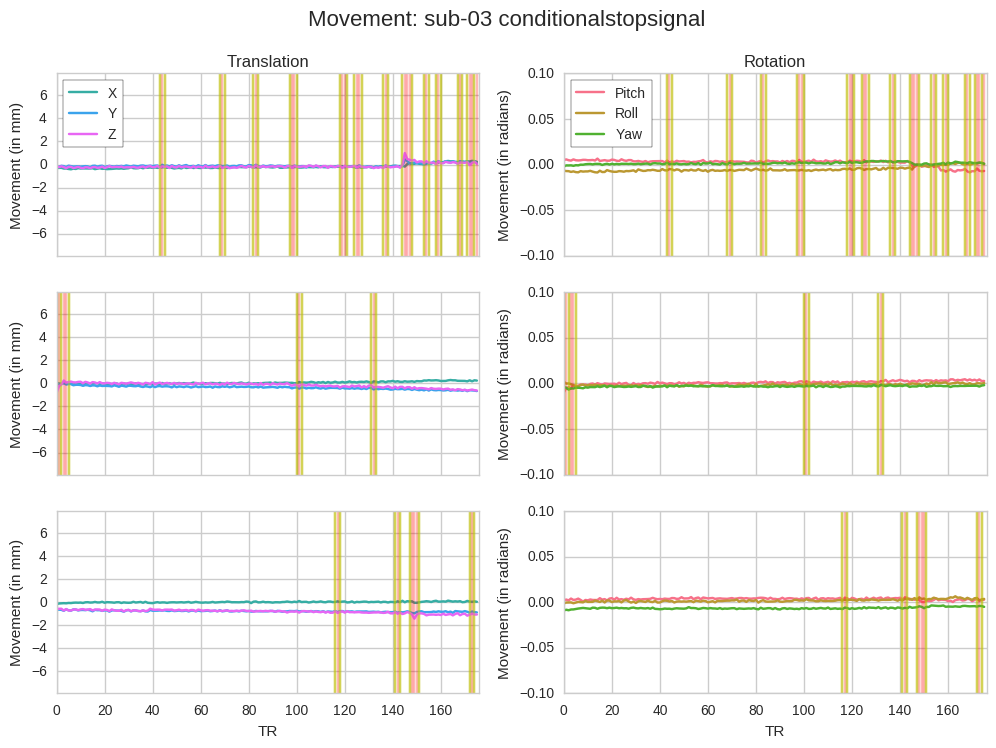

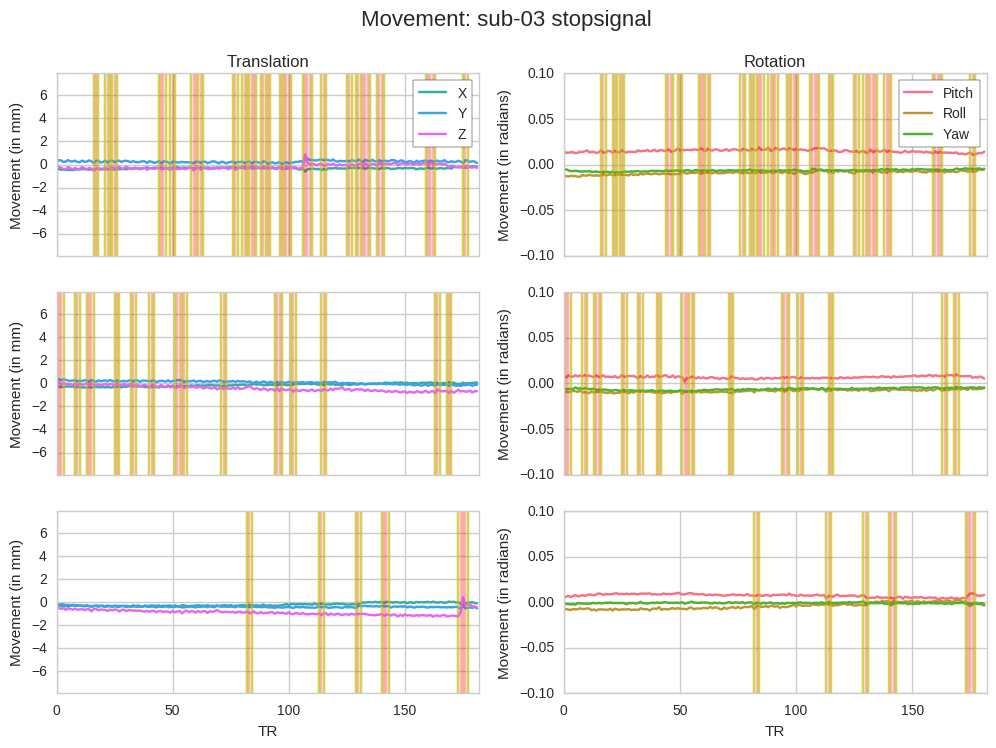

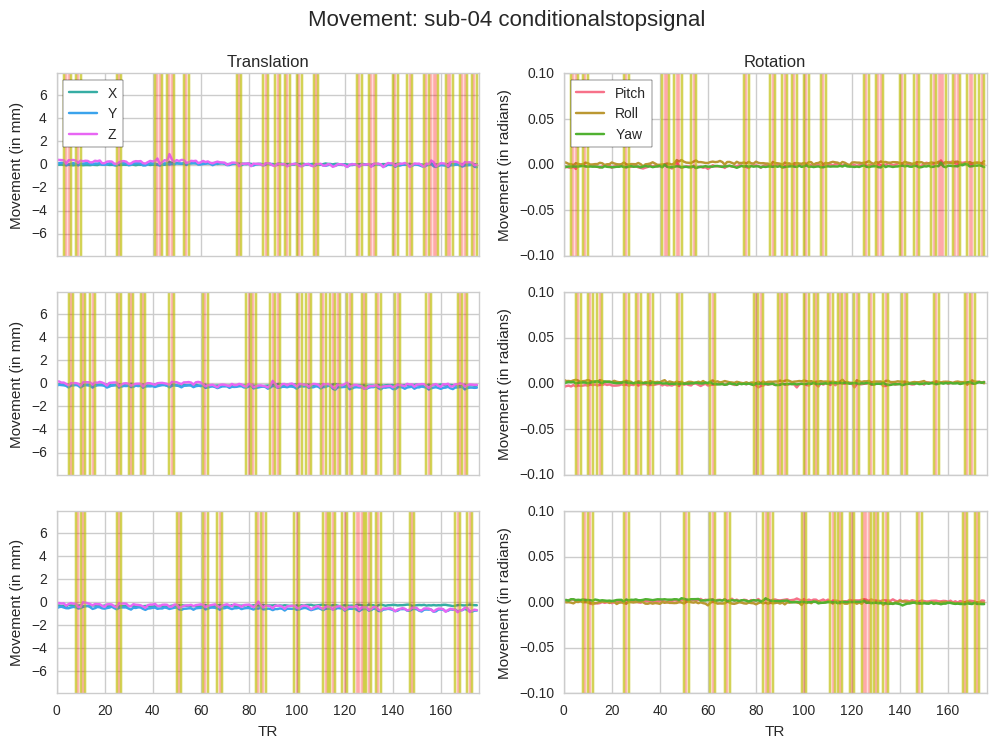

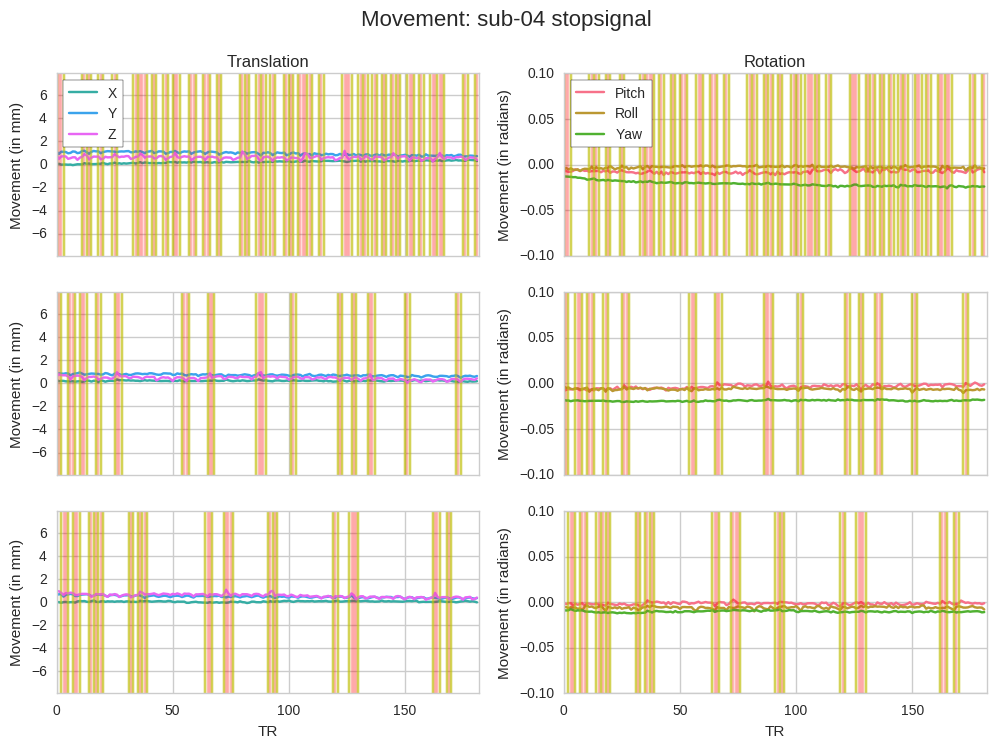

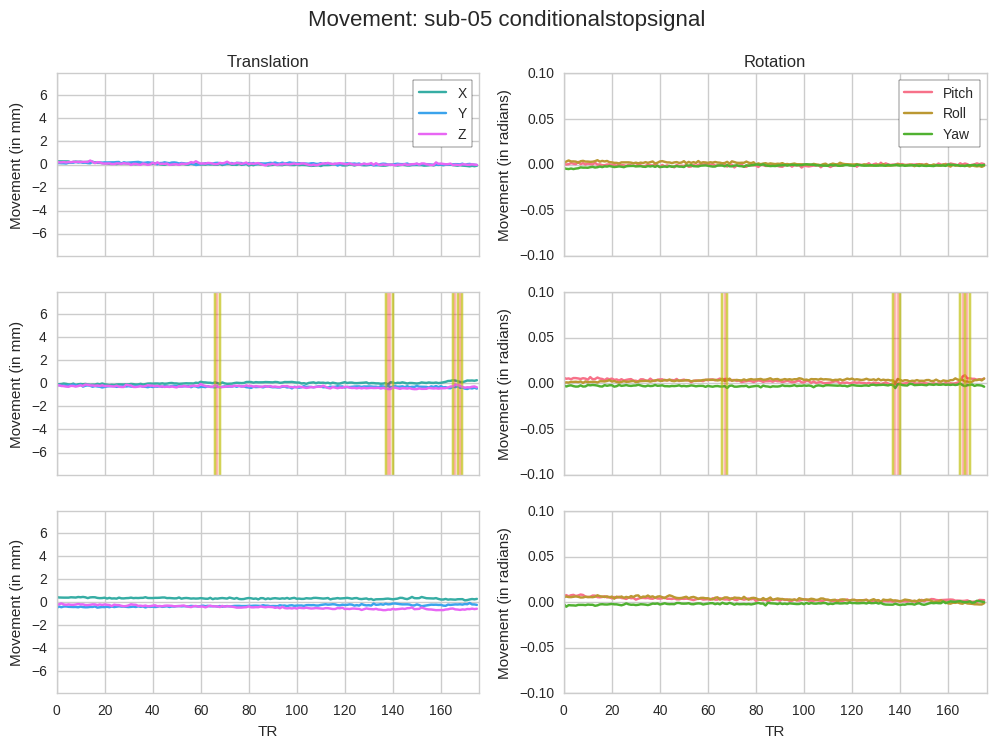

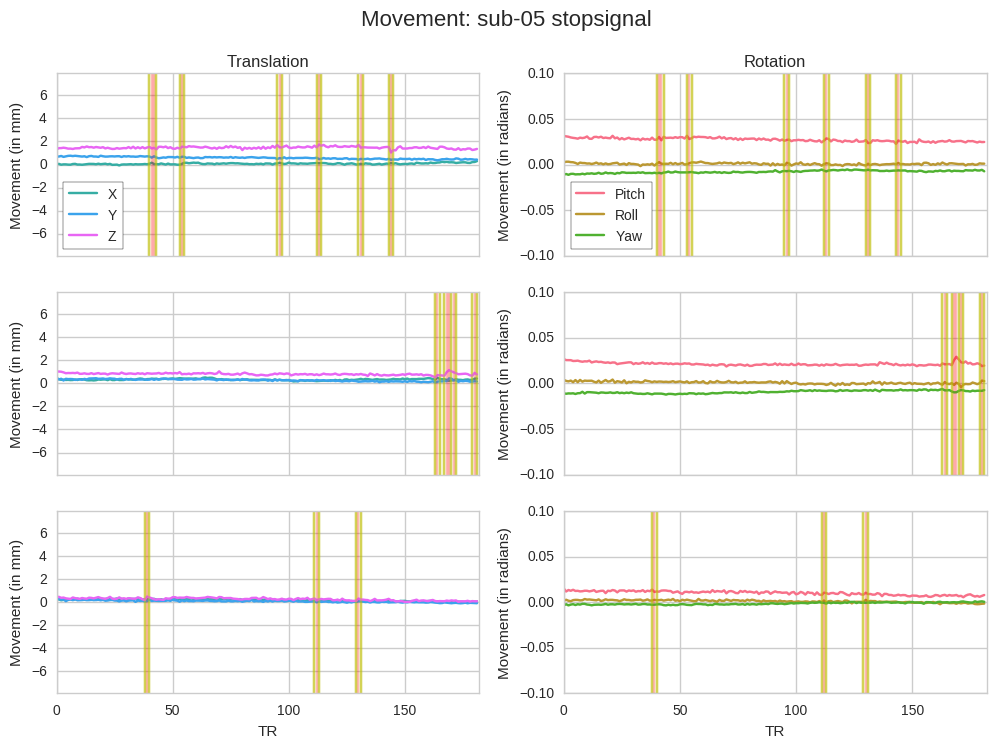

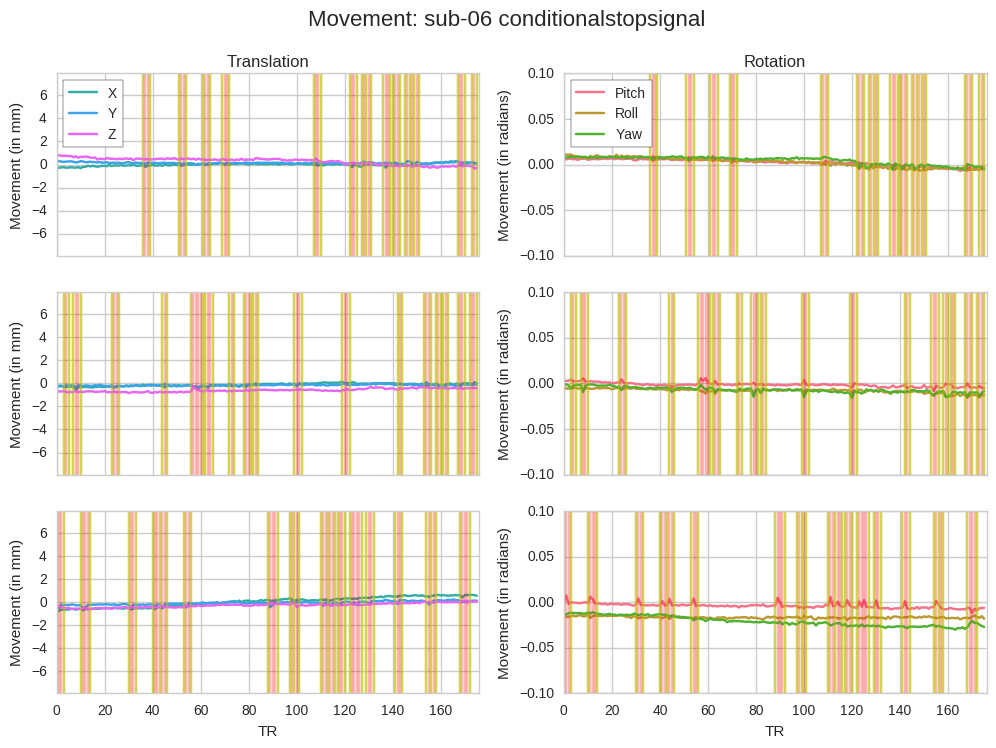

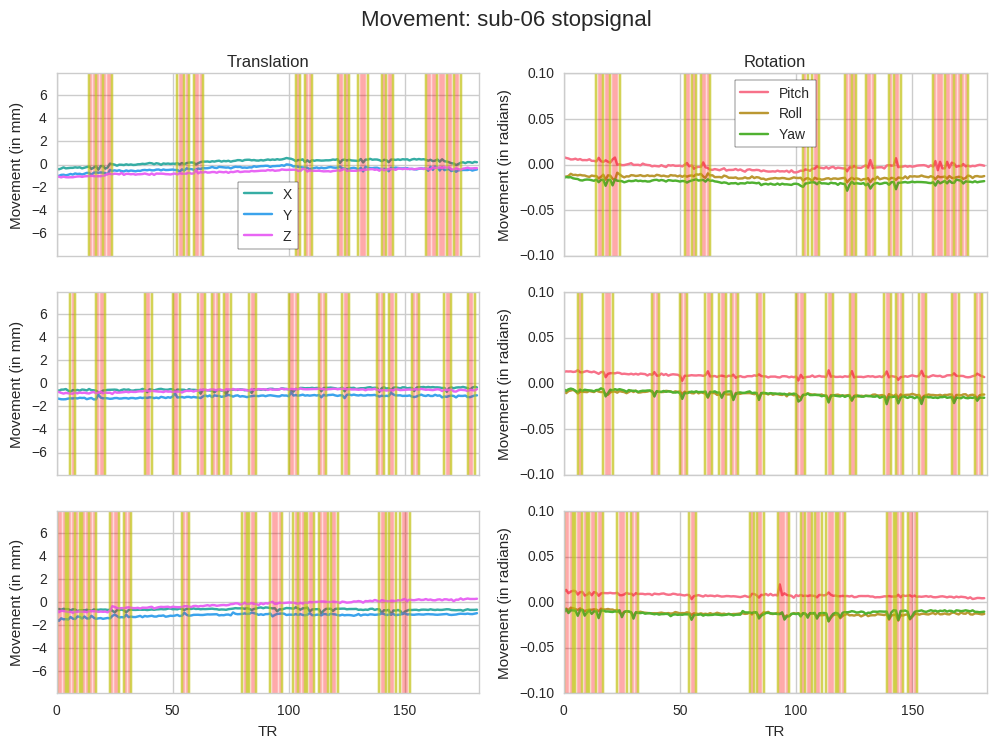

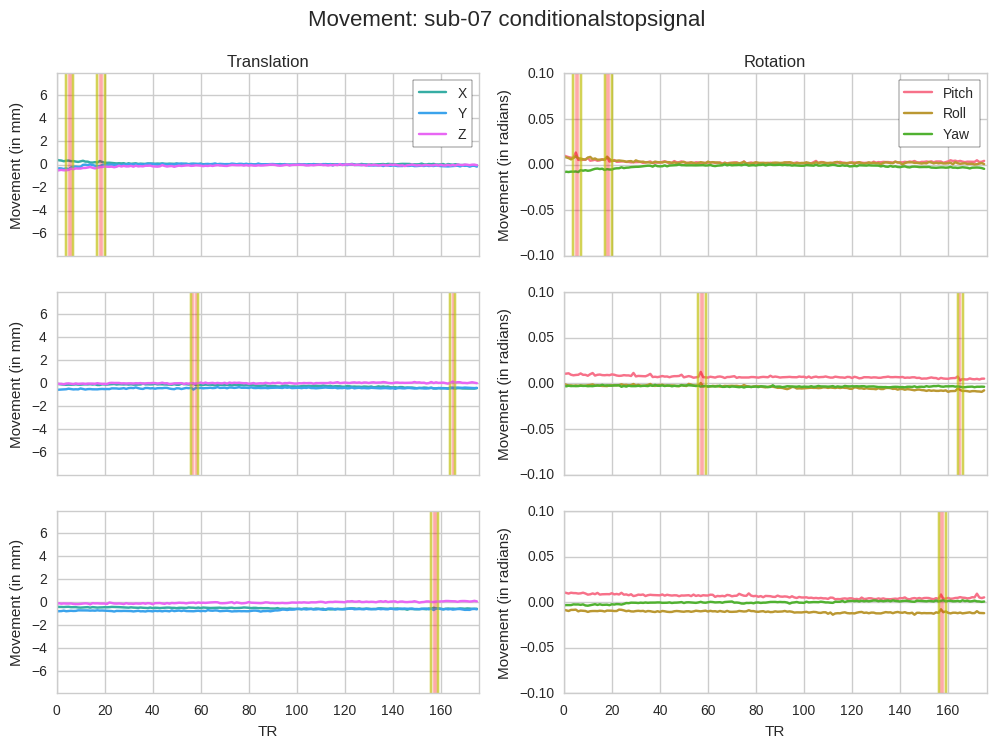

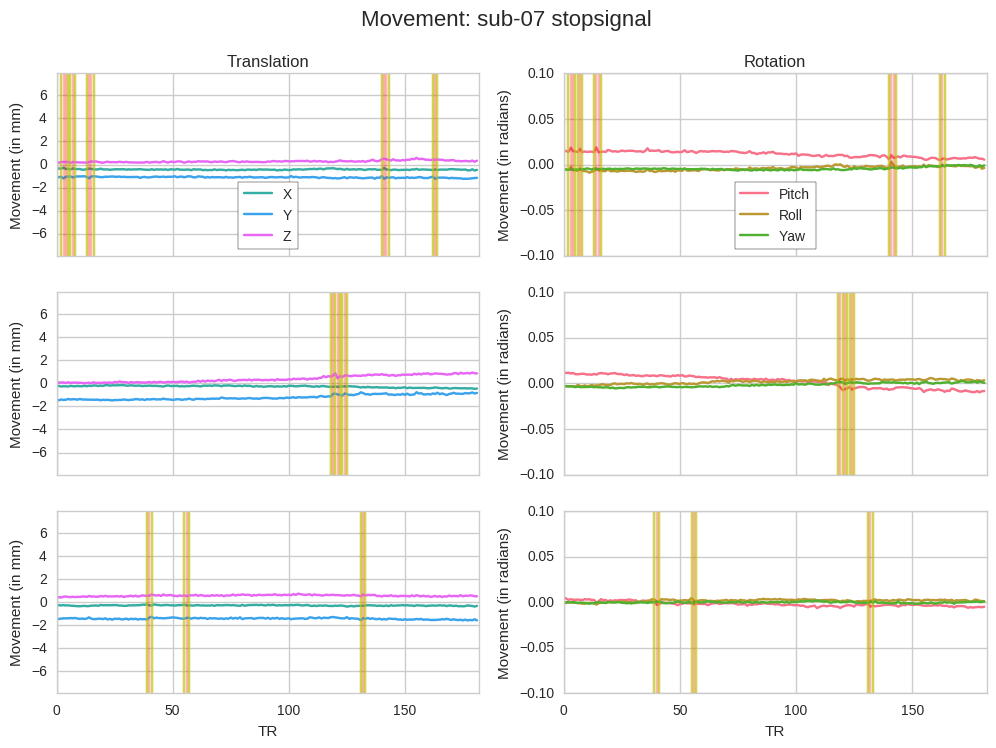

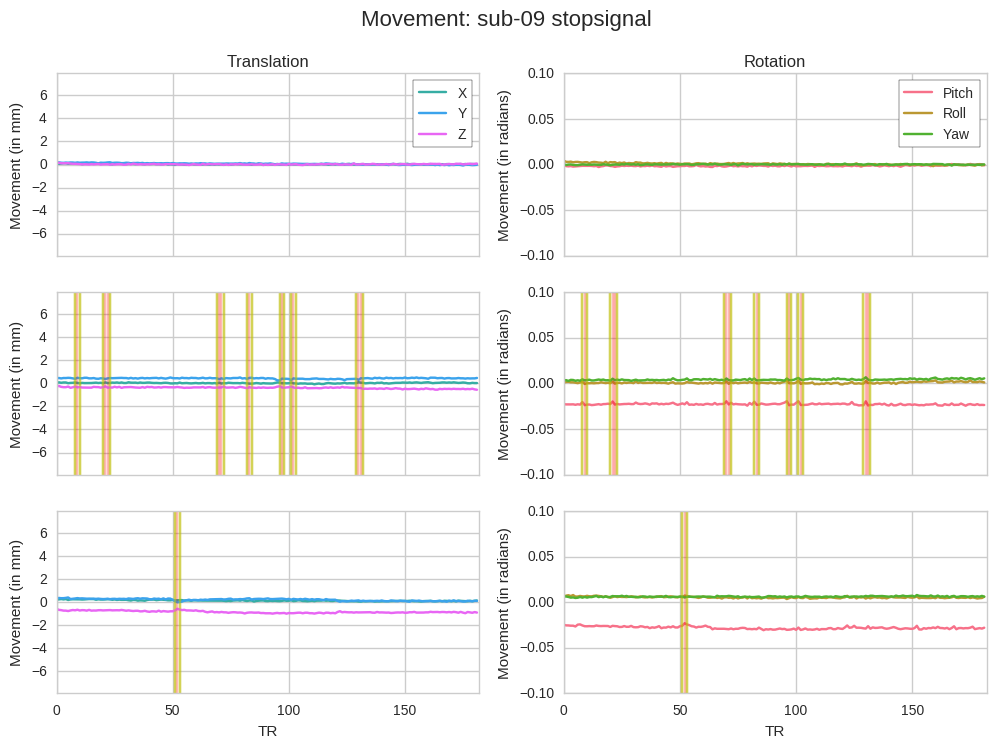

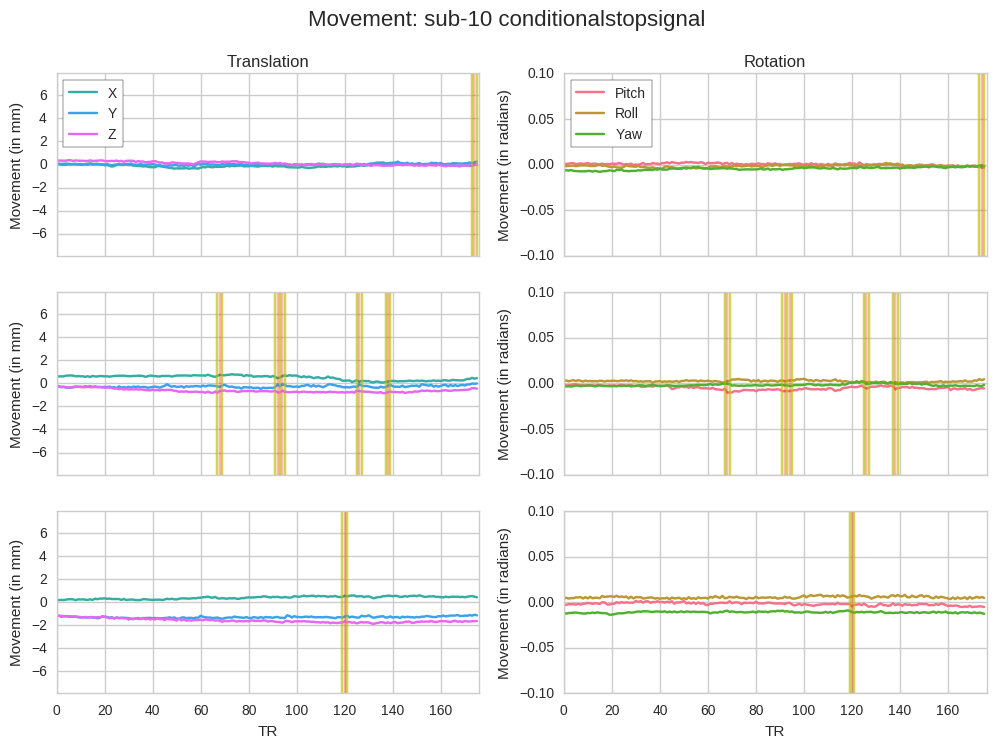

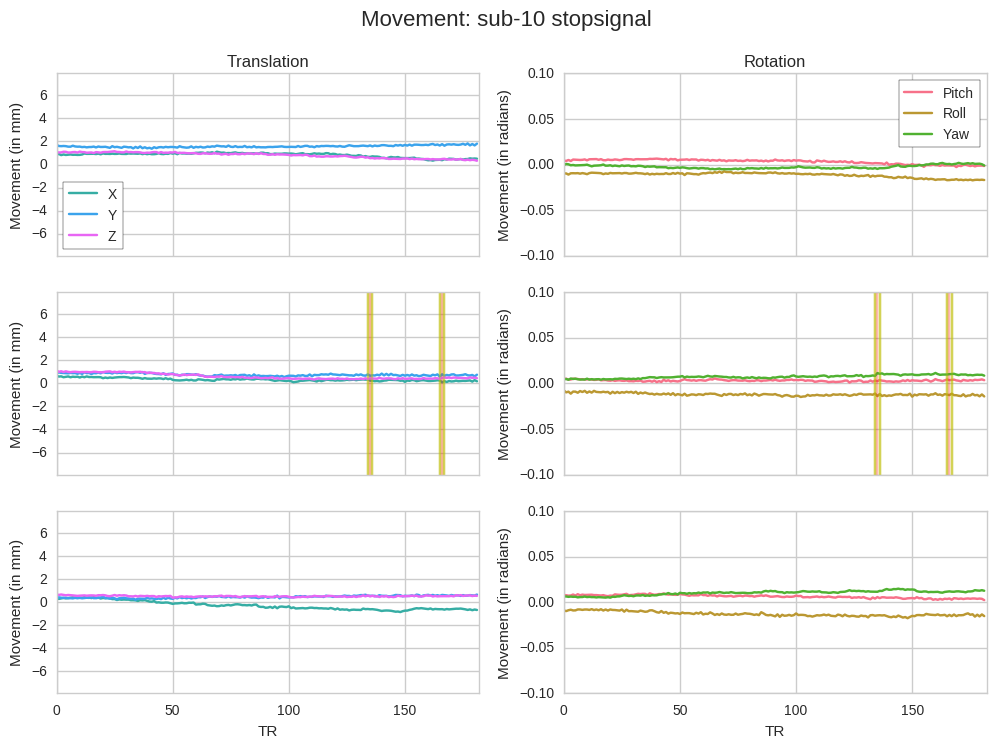

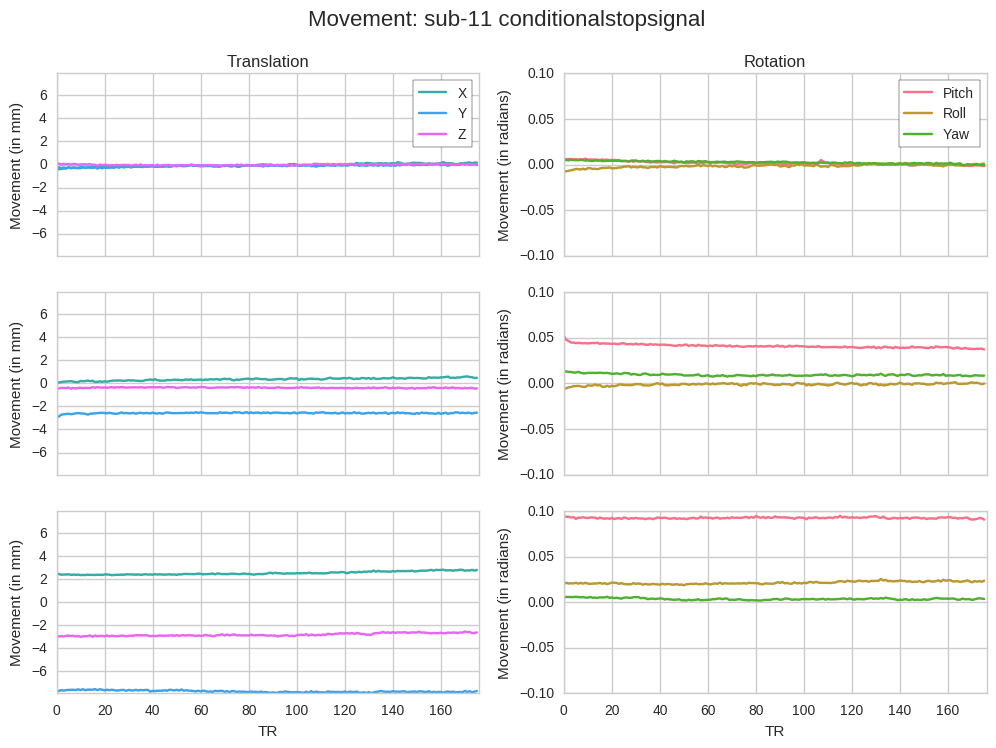

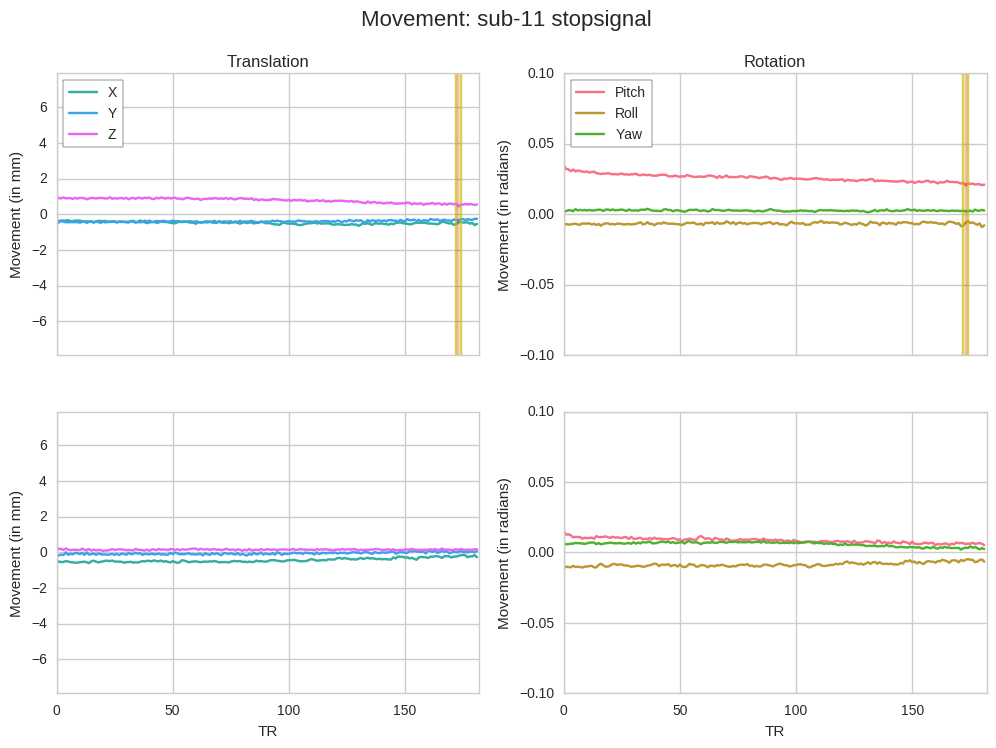

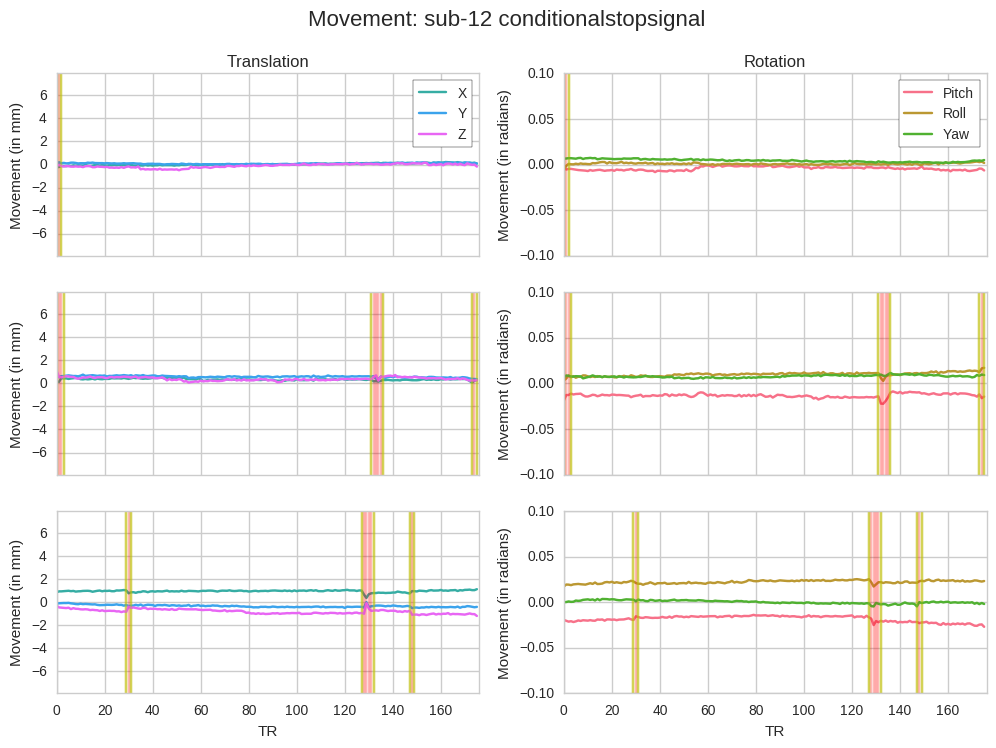

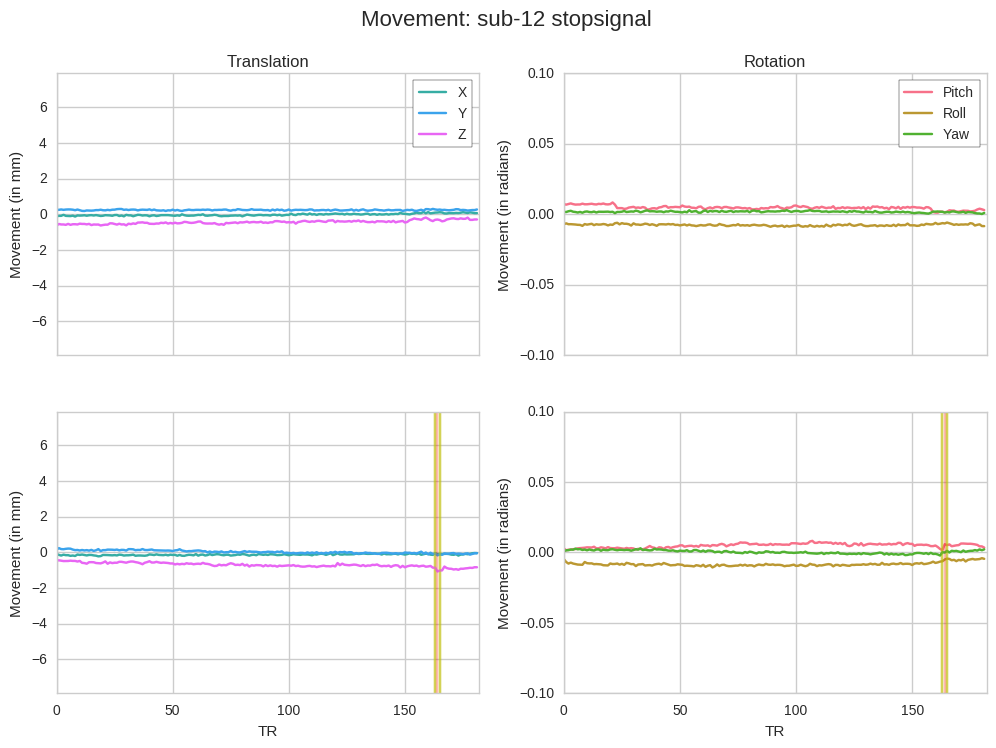

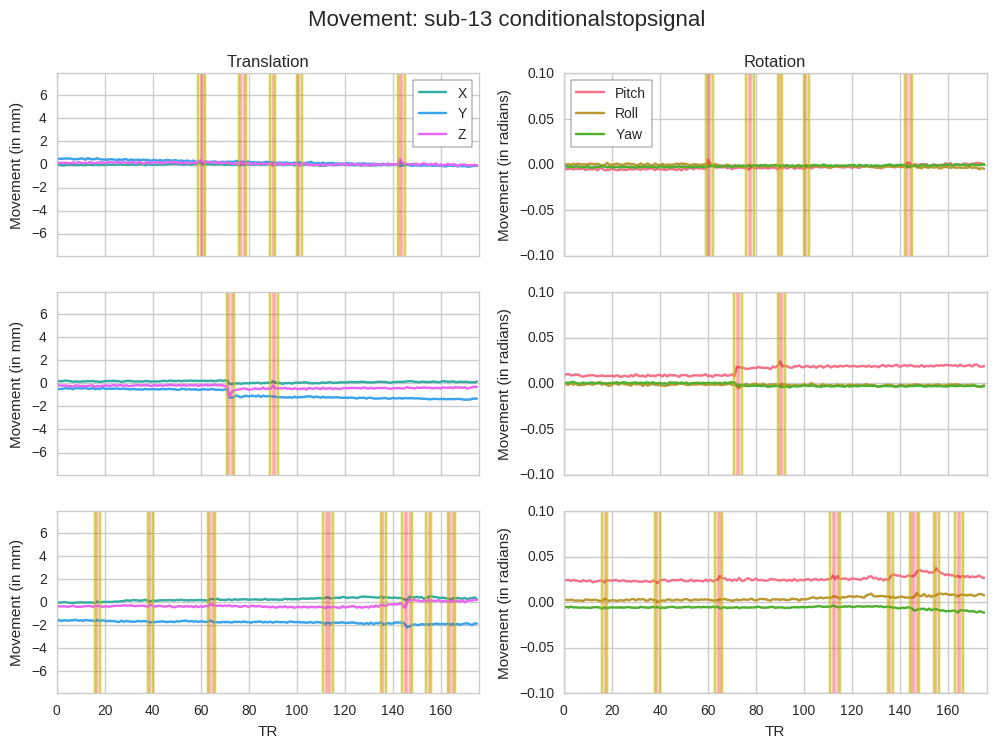

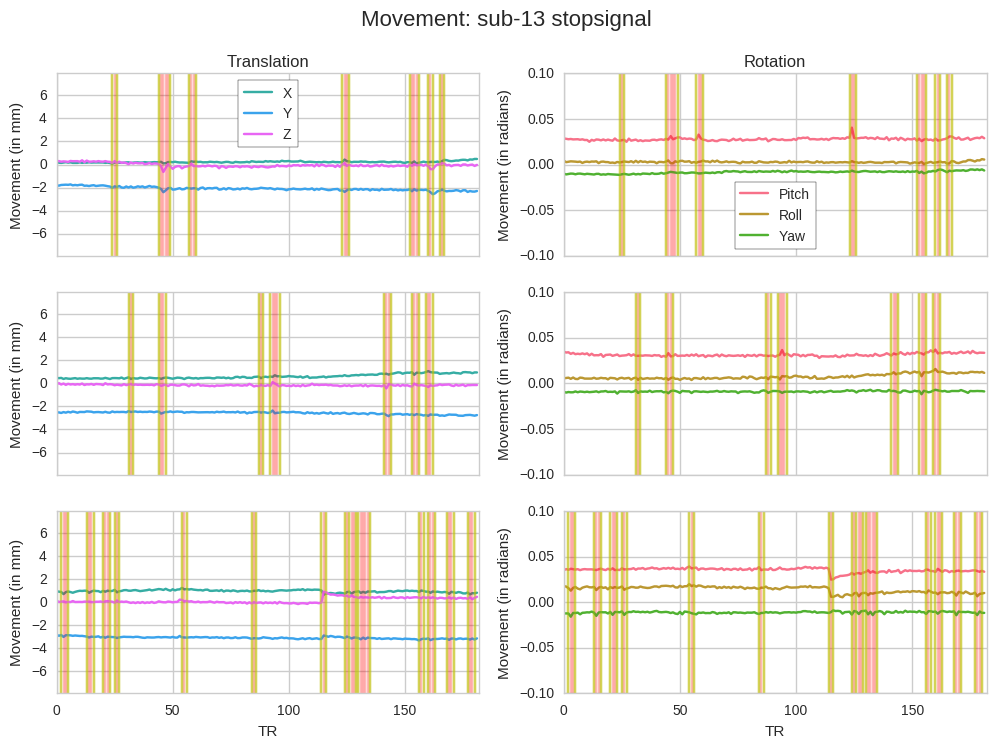

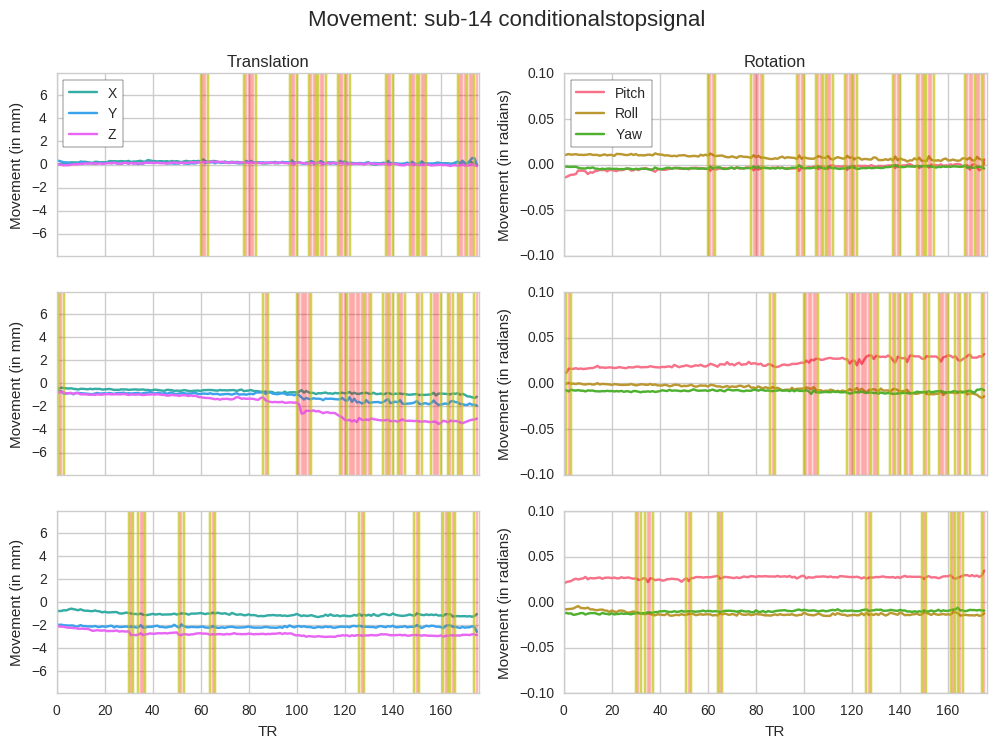

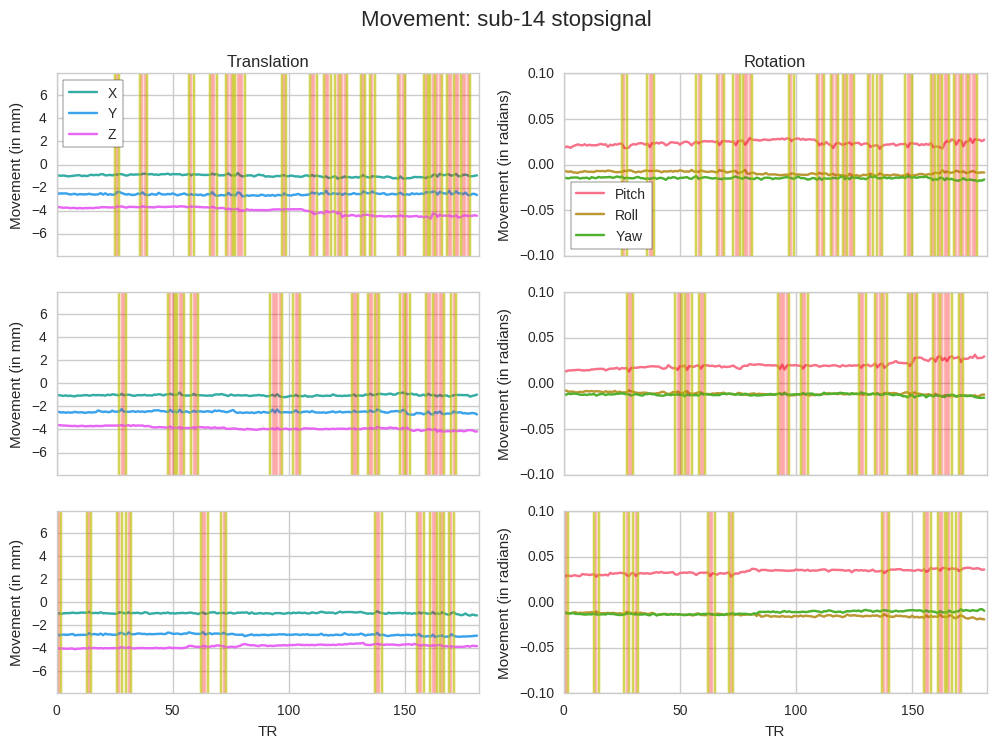

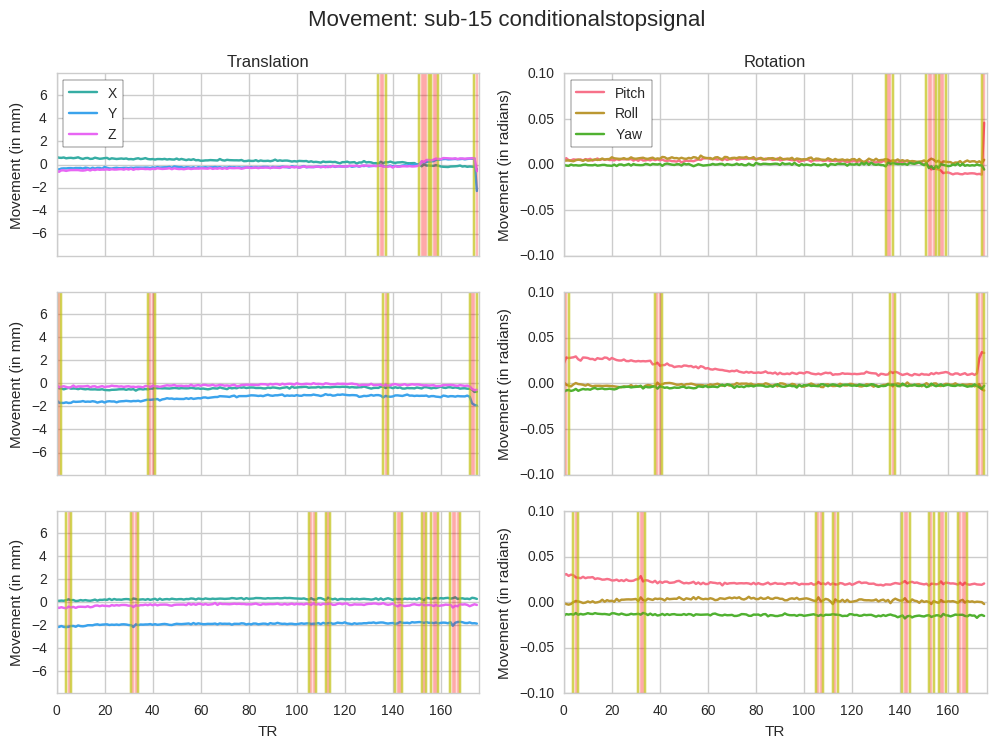

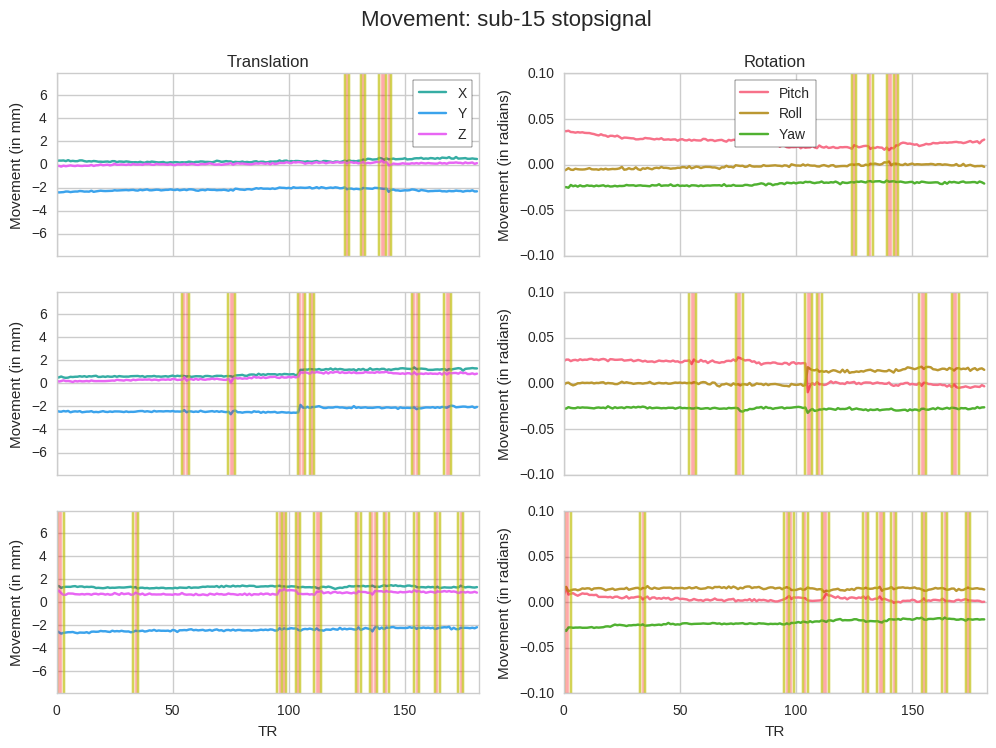

In [5]:
subjects = sorted([basename(f) for f in glob(join(data_dir, 'sub-*'))])
for s in subjects:
    print(s)
    motpar_files = sorted([basename(f) for f in glob(join(data_dir, s, 'preproc/motion/*.par'))])
    tasks = sorted(list(set([re.search('task-(.*)_run', f).group(1) for f in motpar_files])))
    for t in tasks:
        rel_files = sorted([f for f in motpar_files if 'task-{0}_run'.format(t) in f])
        n_runs = len(rel_files)
        fig, axarr = plt.subplots(n_runs, 2)
        fig.suptitle('Movement: {0} {1}'.format(s, t), fontsize=16)

        for run in range(n_runs):
            run_name = re.search('(run-[0-9][0-9])', rel_files[run]).group(0)
            dat = np.loadtxt(join(data_dir, s, 'preproc/motion/', rel_files[run]))
            fd = framewise_displacement(dat)
            cens_vols = np.where(fd>0.5)[0]
            bef_cens_vols = cens_vols - 1
            aft_cens_vols = cens_vols + 1
            all_vols = np.array(range(len(fd)))
            all_cens_vols = np.union1d(bef_cens_vols, aft_cens_vols)
            red_cens_vols = np.intersect1d(all_vols, all_cens_vols)
            red_cens_vols = np.setdiff1d(red_cens_vols, cens_vols)
            
            trans, rot = dat[:, :3], dat[:, 3:]

            for i, rot_dir in enumerate(rot_dirs):
                axarr[run, 1].plot(range(dat.shape[0]), rot[:, i], c=colors[i], label=rot_dir)
                for v in cens_vols:
                    axarr[run, 1].axvline(v, color='r', alpha=0.1)
                
                for v in red_cens_vols:
                    axarr[run, 1].axvline(v, color='y', alpha=0.3)

            axarr[run, 1].set_ylim((-1*r_lim, r_lim))
            axarr[run, 1].set_xlim((0, dat.shape[0]))
            axarr[run, 1].set_ylabel('Movement (in radians)')

            for i, trans_dir in enumerate(trans_dirs):
                axarr[run, 0].plot(range(dat.shape[0]), trans[:, i], c=colors[i+3], label=trans_dir)
                for v in cens_vols:
                    axarr[run, 0].axvline(v, color='r', alpha=0.1)
                
                for v in red_cens_vols:
                    axarr[run, 0].axvline(v, color='y', alpha=0.3)

            axarr[run, 0].set_ylabel('Movement (in mm)')
            if run != n_runs-1:
                axarr[run, 0].set_xticklabels([])
                axarr[run, 1].set_xticklabels([])
            axarr[run, 0].set_ylim((-1*t_lim, t_lim))
            axarr[run, 0].set_xlim((0, dat.shape[0]))
        
        axarr[0, 1].set_title('Rotation')
        axarr[0, 0].set_title('Translation')
        axarr[-1, 0].set_xlabel('TR')
        axarr[-1, 1].set_xlabel('TR')

        legend = axarr[0, 0].legend(frameon=True, loc='best')
        frame = legend.get_frame()
        frame.set_facecolor('white')
        frame.set_edgecolor('black')

        legend = axarr[0, 1].legend(frameon=True, loc='best')
        frame = legend.get_frame()
        frame.set_facecolor('white')
        frame.set_edgecolor('black')
        
        fig.savefig(join(out_dir, '{0}-{1}.png'.format(s, t)), dpi=400)